In [2]:
# file_path = 'paper_review_results_04_07/paper_review_final_labels_04_07.json'
file_path = 'paper_review_final_labels_05_12.json'
data = []
with open(file_path, 'r') as file:
    for line in file:
        data.append(json.loads(line.strip()))

categories = data[0]['human'][0].keys()

def generating_pairs(list_of_vecs):
    samples = []
    for j in range(len(list_of_vecs)):
        gpt3_vec_list = list_of_vecs[j]['gpt-3.5-turbo']
        gpt4_vec_list = list_of_vecs[j]['gpt-4o-mini']
        phi_vec_list = list_of_vecs[j]['Phi-3.5-mini-instruct']
        mistral_vec_list = list_of_vecs[j]['Mistral-7B-Instruct-v0.3']
        gemma_vec_list = list_of_vecs[j]['gemma-2-2b-it']
        human_vec_list = list_of_vecs[j]['human']
        vec_list = []
        for i in range(3):
            if human_vec_list[i] != None:
                vec = [human_vec_list[i][key] for key in categories]
                vec_list.append(vec)
            else:
                vec_list.append([])
        # print(list_of_vecs[j]['paper_id'], vec_list)
            # else:
            #     vec_list.append(None)
        for i in range(3):
            if gpt3_vec_list[i] != None:
                vec = [gpt3_vec_list[i][key] for key in categories]
                vec_list.append(vec)
            else:
                vec_list.append([])
        for i in range(3):
            if gpt4_vec_list[i] != None:
                vec = [gpt4_vec_list[i][key] for key in categories]
                vec_list.append(vec)
            else:
                vec_list.append([])
        for i in range(3):
            if phi_vec_list[i] != None:
                vec = [phi_vec_list[i][key] for key in categories]
                vec_list.append(vec)
            else:
                vec_list.append([])
        for i in range(3):
            if mistral_vec_list[i] != None:
                vec = [mistral_vec_list[i][key] for key in categories]
                vec_list.append(vec)
            else:
                vec_list.append([])
        for i in range(3):
            if gemma_vec_list[i] != None:
                vec = [gemma_vec_list[i][key] for key in categories]
                vec_list.append(vec)
            else:
                vec_list.append([])
        samples.append(vec_list)
    return samples

pairs = generating_pairs(data)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def conditioned_cosine_similarity(X, Y, Z):
    # Step 1: Normalize Z
    Z_norm = Z / np.linalg.norm(Z)

    # Step 2: Project X and Y onto Z
    X_Z = np.dot(Z_norm, X) * Z_norm
    Y_Z = np.dot(Z_norm, Y) * Z_norm

    # Step 3: Get the orthogonal components of X and Y
    X_orth = X - X_Z
    # print(X_orth)
    Y_orth = Y - Y_Z
    # print(Y_orth)

    # Step 4: Compute cosine similarity between the orthogonal components
    if np.linalg.norm(X_orth) == 0 or np.linalg.norm(Y_orth) == 0:
        return 0
    similarity = np.dot(X_orth, Y_orth) / (np.linalg.norm(X_orth) * np.linalg.norm(Y_orth))
    return similarity


In [8]:
import numpy as np

def compute_dimension_probabilities(data, possible_values=(-1, 0, 1), dimension_size=len(categories)):
    """
    Compute the probability of each possible value appearing at each dimension index,
    after mapping -2 to -1 and 2 to 1.

    Args:
        data (list): A nested list of lists of vectors (ragged 3D array).
        possible_values (tuple): Values to consider for counting probabilities.
        dimension_size (int): The number of dimensions in each vector.

    Returns:
        np.ndarray: A (dimension_size x len(possible_values)) array of probabilities.
    """
    # Initialize count matrix
    counts = np.zeros((dimension_size, len(possible_values)))

    # Iterate through all vectors
    for outer in data:
        for vec in outer:
            if len(vec) == 0:
                continue  # skip empty vectors
            for i, val in enumerate(vec):
                # Map -2 -> -1 and 2 -> 1
                if val == -2:
                    val = -1
                elif val == 2:
                    val = 1

                if val in possible_values:
                    index = possible_values.index(val)
                    counts[i, index] += 1

    # Compute probabilities
    probabilities = np.zeros_like(counts)
    for i in range(dimension_size):
        total = counts[i].sum()
        if total > 0:
            probabilities[i] = counts[i] / total

    return probabilities


prior_matrix = compute_dimension_probabilities(pairs)
print('Signal prior of each dimension', prior_matrix)


Signal prior of each dimension [[0.21609604 0.59915518 0.18474878]
 [0.30691418 0.29913295 0.39395287]
 [0.55980436 0.27667852 0.16351712]
 [0.02278791 0.89684304 0.08036905]
 [0.01445087 0.96576256 0.01978657]
 [0.04290796 0.94430858 0.01278346]
 [0.27523344 0.35660293 0.36816363]
 [0.41462872 0.14606492 0.43930636]
 [0.0655847  0.47076478 0.46365051]
 [0.06936416 0.0560249  0.87461094]
 [0.15807025 0.45675856 0.38517119]
 [0.22543353 0.47876834 0.29579813]
 [0.3963984  0.40618052 0.19742108]
 [0.00822588 0.9006225  0.09115162]
 [0.22787906 0.70753668 0.06458426]
 [0.5819253  0.34470876 0.07336594]
 [0.0047799  0.17507781 0.82014229]
 [0.28234771 0.41518453 0.30246776]
 [0.06991996 0.55302357 0.37705647]]


In [10]:
import random
import copy
m = 8
alpha_llm = 0.05
alpha_prior = 0.05
n_human = int(1500/m*(1-alpha_llm-alpha_prior))+1
n_llm = int(1500/m*alpha_llm)+1
n_prior = int(1500/m*alpha_prior)+1
cheater_llm = 'GPT-4'
values = np.array([-1, 0, 1])

def simulate_review(n_human, n_llm, n_prior, n_random, llm_index):
    review_simulated = np.ones((n_human+n_llm+n_prior+n_random, len(data), len(categories)))*np.nan
    remaining_review = copy.deepcopy(pairs)
    remaining_index = list(range(len(data)))
    
    for i in range(n_human):
        if len(remaining_index) >= m:
            index = random.sample(remaining_index, k=m)
        else:
            index = remaining_index
            remaining_index = list(range(len(data)))
            tmp = [x for x in remaining_index if x not in index]
            index += random.sample(tmp, k=(m-len(index)))
        for j in index:
            for l in [0,1,2]:
                if len(remaining_review[j][l]) != 0:
                    review_simulated[i,j] = np.array(remaining_review[j][l])
                    remaining_review[j][l] = []
                    break
            # if len(remaining_review[j][0]) + len(remaining_review[j][1]) + len(remaining_review[j][2]) == 0:
            remaining_index.remove(j)
    
    
    for i in range(n_llm):
        if len(remaining_index) >= m:
            index = random.sample(remaining_index, k=m)
        else:
            index = remaining_index
            remaining_index = list(range(len(data)))
            tmp = [x for x in remaining_index if x not in index]
            index += random.sample(tmp, k=(m-len(index)))
        for j in index:
            for l in llm_index:
                if len(remaining_review[j][l]) != 0:
                    review_simulated[n_human+i,j] = np.array(remaining_review[j][l])
                    remaining_review[j][l] = []
                    break
            # if len(remaining_review[j][begin_index]) + len(remaining_review[j][begin_index+1]) == 0:
            remaining_index.remove(j)

    for i in range(n_prior):
        if len(remaining_index) >= m:
            index = random.sample(remaining_index, k=m)
        else:
            index = remaining_index
            remaining_index = list(range(len(data)))
            tmp = [x for x in remaining_index if x not in index]
            index += random.sample(tmp, k=(m-len(index)))
        for j in index:
            sampled_vector = np.array([
                np.random.choice(values, p=prior_matrix[i])
                for i in range(prior_matrix.shape[0])
            ])
            review_simulated[n_human+n_llm+i,j] = sampled_vector
    for i in range(n_random):
        if len(remaining_index) >= m:
            index = random.sample(remaining_index, k=m)
        else:
            index = remaining_index
            remaining_index = list(range(len(data)))
            tmp = [x for x in remaining_index if x not in index]
            index += random.sample(tmp, k=(m-len(index)))
        for j in index:
            sampled_vector = np.array([
                np.random.choice(values, p=[1/3,1/3,1/3])
                for i in range(prior_matrix.shape[0])
            ])
            review_simulated[n_human+n_llm+n_prior+i,j] = sampled_vector
    return review_simulated


In [896]:
from sklearn.metrics import roc_auc_score
def compute_similarity_score(review_simulated, llm_conditioned):
    n, m_total, k = review_simulated.shape
    scores = np.zeros(n)
    scores_cond = np.zeros(n)
    scores_dist = np.zeros(n)
    for i in range(n):
        ct_ii = 0
        ct_i = 0
        valid_tasks = ~np.isnan(review_simulated[i, :, 0])
        for j in np.where(valid_tasks == True)[0]:
            valid_agents = ~np.isnan(review_simulated[:, j, 0])
            xi = review_simulated[i,j]
            s3 = cosine_similarity(xi,llm_conditioned[j])
            scores_dist[i] -= s3
            ct_i += 1
            for ii in np.where(valid_agents == True)[0]:
                if ii != i:
                    yi = review_simulated[ii,j]
                    # s = - cosine_similarity(xi,llm_conditioned[j])
                    s1 = conditioned_cosine_similarity(xi, yi, llm_conditioned[j])
                    s2 = cosine_similarity(xi,yi)
                    ct_ii += 1
                    scores[i] += s2
                    scores_cond[i] += s1
        if ct_ii > 0:
            scores[i] /= ct_ii
            scores_cond[i] /= ct_ii
            scores_dist[i] /= ct_i
        else:
            print('no valid peers')
    return scores, scores_cond, scores_dist

In [ ]:
import warnings
warnings.filterwarnings('ignore')

m = 5 # number of reviews per reviewer
values = np.array([-1, 0, 1])
llm_conditioned = np.zeros((len(data), len(categories)))

T = 100

AUC_scores = np.zeros((5, T*3)) # direct cosine similarity
AUC_scores_cond = np.zeros((5, T*3)) # cosine similarity after projecting on the space orthogonal to Z
AUC_scores_dist = np.zeros((5, T*3)) # negative distance to Z

for ll in range(5):
    for t in range(T):
        
        r1 = np.random.rand()
        r2 = np.random.rand()
        r3 = np.random.rand()
        alpha_llm = 0.1*r1
        alpha_prior = 0.1*r2
        alpha_random = 0.1*r3
        n_human = int(1500/m*(1-alpha_llm-alpha_prior-alpha_random))+1
        n_llm = int(1500/m*alpha_llm)+1
        n_prior = int(1500/m*alpha_prior)+1
        n_random = int(1500/m*alpha_random)
        identity = np.zeros(n_human+n_llm+n_prior+n_random)
        identity[:n_human] = 1
        for b in range(3):
            
            cond_index = (ll+1)*3+b
            llm_index = [(ll+1)*3, (ll+1)*3+1, (ll+1)*3+2]
            llm_index.remove(cond_index)
            for j in range(len(data)):
                if len(pairs[j][cond_index]) > 0:
                    llm_conditioned[j] = pairs[j][cond_index]
                else:
                    llm_conditioned[j] = np.ones(len(categories))*np.nan
        
            
            review_simulated = simulate_review(n_human, n_llm, n_prior, n_random, llm_index)
            scores, scores_cond, scores_dist = compute_similarity_score(review_simulated, llm_conditioned)
            mask = ~np.isnan(scores)
            auc = roc_auc_score(identity[mask], scores[mask])
            AUC_scores[ll,b*T+t] = auc
            
            mask = ~np.isnan(scores_cond)
            auc = roc_auc_score(identity[mask], scores_cond[mask])
            AUC_scores_cond[ll,b*T+t] = auc

            mask = ~np.isnan(scores_dist)
            auc = roc_auc_score(identity[mask], scores_dist[mask])
            AUC_scores_dist[ll,b*T+t] = auc

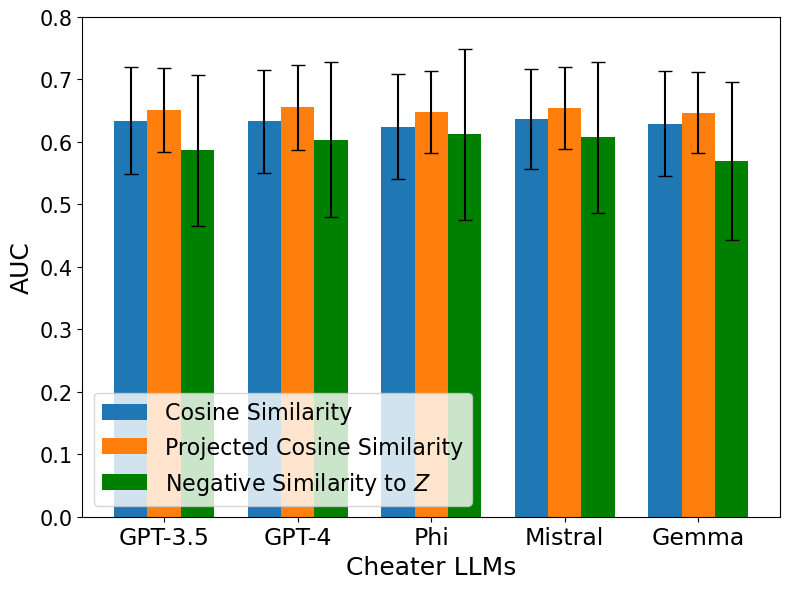

In [968]:
x = np.arange(5)  # 5 groups
width = 0.25      # narrower width to accommodate 3 bars

fig, ax = plt.subplots(figsize=(8, 6))

# Bars for A
bars_A = ax.bar(x - width, np.average(AUC_scores, axis=1), width, 
                yerr=np.std(AUC_scores, axis=1), capsize=5, label='Cosine Similarity')

# Bars for B
bars_B = ax.bar(x, np.average(AUC_scores_cond, axis=1), width, 
                yerr=np.std(AUC_scores_cond, axis=1), capsize=5, label='Projected Cosine Similarity')

# Bars for C (new green bars)
bars_C = ax.bar(x + width, np.average(AUC_scores_dist, axis=1), width, 
                yerr=np.std(AUC_scores_dist, axis=1), capsize=5, color='green', label=r'Negative Similarity to $Z$')

# Labels and title
LLM_names = ['GPT-3.5', 'GPT-4', 'Phi', 'Mistral', 'Gemma']
ax.set_xlabel('Cheater LLMs', fontsize=18)
ax.set_ylabel('AUC', fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(LLM_names, fontsize=17)
ax.legend(fontsize=16)
ax.set_ylim(0, 0.8)
ax.tick_params(axis='y', labelsize=15)

plt.tight_layout()